In [ ]:
from ordpy import complexity_entropy as true_com, minimum_complexity_entropy, maximum_complexity_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from math import log, pow, factorial

In [63]:
# 1) time_series -> embeddings
def embed_time_series(data, m, tau=1):
    #print('Embedding...')
    n = len(data)
    embedded = np.array([data[i:i + m * tau:tau] for i in range(n - (m - 1) * tau)])
    return embedded

# 2) z_vector -> pattern (one of m!) 
def ordinal_sequence(z_i):
    return ''.join(map(str, np.argsort(z_i)))

# 3) embeddings -> pattern distribution
def probalize_embeddings(emb):
    p_res = {}
    N, m = emb.shape
    for e in emb:
        pat = ordinal_sequence(e)
        p_res[pat] = p_res.get(pat, 0) + 1
    for k in p_res.keys():
        p_res[k] = p_res[k] / N
    p_res = list(p_res.values())
    return np.array(p_res) 


In [141]:
def shennon(p):
    if isinstance(p, np.ndarray):
        return -np.sum(p * np.log(p))
    else:
        return np.log(p)

def p_e(M):
    return 1/M

# 4) H[P]
def entropy(p, M):
    S_P = shennon(p)
    S_max = shennon(M)
    return S_P / S_max

# 4) C[P]
def q_complexity(p, n):
    n_p_zeros = n-len(p)
    p_e          = 1/n
    p_pe  = (p_e + p)/2  
    s0 = shennon(p_pe) - (0.5*p_e)*np.log(0.5*p_e)*n_p_zeros
    s1 = shennon(p)/2
    s2 = shennon(n)/2

    Q_0 = -0.5*(((n+1)/n)*np.log(n+1) + np.log(n) - 2*np.log(2*n))    
    J_ppe = s0 - s1 - s2

    return J_ppe/Q_0

In [143]:
def complexity_entropy(ts, m, tau=1):
    exp_M = factorial(m)
    pattern_dist = probalize_embeddings(embed_time_series(ts, m, tau))
    #print(f'Распределение с {pattern_dist.shape[0]} паттернами')
    H = entropy(pattern_dist, exp_M)
    Q = q_complexity(pattern_dist, exp_M)
    return H, Q * H

# Experiments

## TS plots

In [144]:
time_series = {}
res = {}

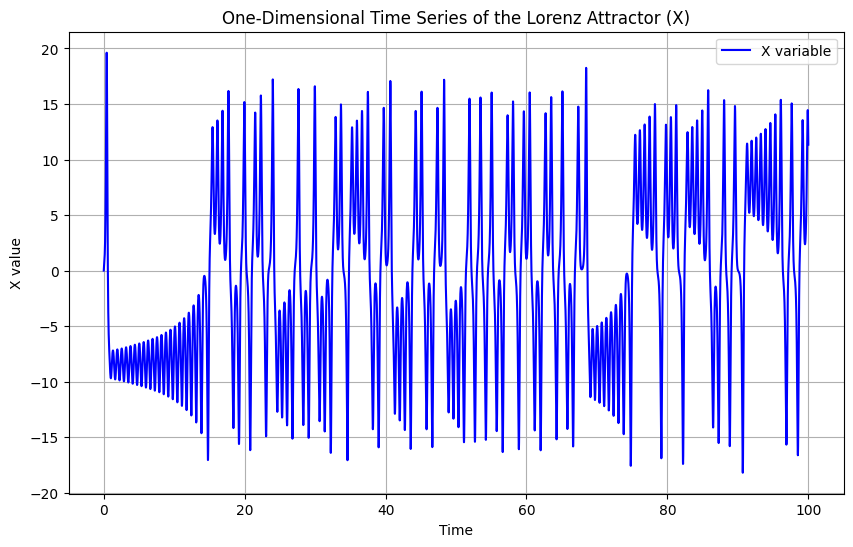

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Lorenz parameters and initial conditions
sigma, beta, rho = 10, 2.667, 28
u0, v0, w0 = 0, 1, 1.05

# Maximum time point and total number of time points
tmax, n = 100, 10000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    u, v, w = X
    up = sigma * (v - u)
    vp = rho * u - v - u * w
    wp = -beta * w + u * v
    return up, vp, wp

# Integrate the Lorenz equations
soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho), dense_output=True)

# Interpolate solution onto the time grid t
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

time_series['lorenz'] = {'ts': x, 'm': 6, 'tau': 10}

# Plotting one-dimensional time series for x variable
plt.figure(figsize=(10, 6))
#plt.plot(time_series)
plt.plot(t, x, color='b', label='X variable')
plt.title('One-Dimensional Time Series of the Lorenz Attractor (X)')
plt.xlabel('Time')
plt.ylabel('X value')
plt.grid()
plt.legend()
plt.show()

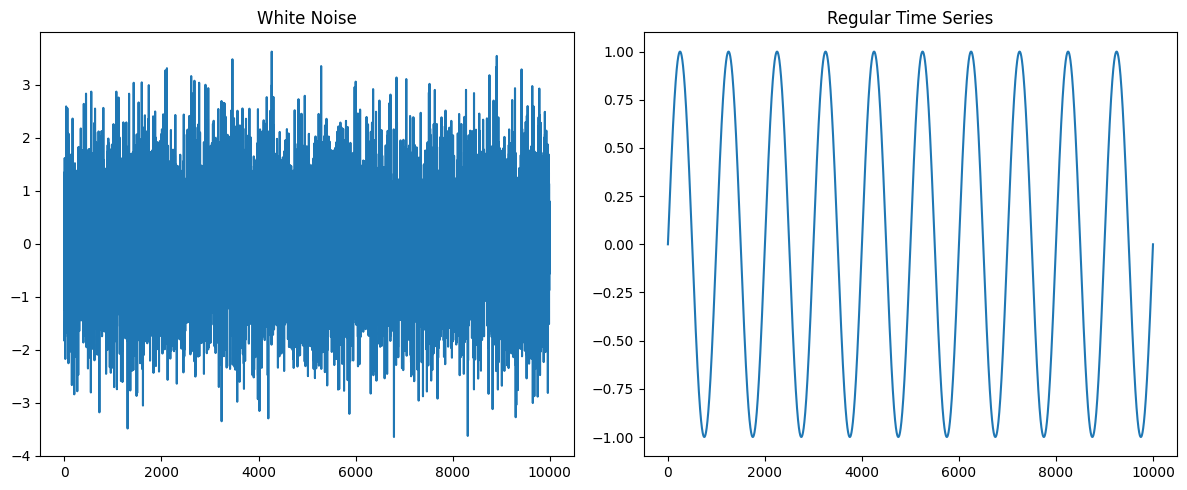

In [157]:
# 1. Henon Map
import warnings
def henon_map(n=2**15, a=1.4, b=0.3, x0=.5, y0=.5):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
            
        bool_ = False
        while bool_==False:        
            try:
                x    = np.zeros(n)
                y    = np.zeros(n)

                x[0] = x0
                y[0] = y0

                for i in range(1, n):
                    x[i] = 1 - a*x[i-1]**2 + y[i-1]
                    y[i] = b*x[i-1]

                bool_ = True

            except RuntimeWarning: #changes the random inital condition
                x0 = np.random.uniform()
                y0 = np.random.uniform()

    return x, y

# 2. Skew tent map
def skew_tent_map(n=10000, omega=0.1847, x0=.5):
    x    = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    return x

# 3. Logistic Map
def logistic_map(n=10000, r=4, x0=0.4):
    x    = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
        
    return x

# 4. Schuster Map
def schuster_map(n=10000, z=2, x0=.5):
    z    = float(z)
    x    = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    
    return x

# 5. White Noise
def white_noise(steps=10000):
    return np.random.normal(0, 1, steps)

# 6. Regular Time Series without Noise
def regular_time_series(frequency=1, amplitude=1, steps=10000):
    t = np.linspace(0, 20*np.pi, steps)
    return amplitude * np.sin(frequency * t)

noise = white_noise()
regular_series = regular_time_series()

time_series['gauss'] = {'ts': noise, 'm': 6, 'tau':10}
time_series['sin'] = {'ts': regular_series, 'm': 6}

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('White Noise')
plt.plot(noise)

plt.subplot(1, 2, 2)
plt.title('Regular Time Series')
plt.plot(regular_series)

plt.tight_layout()
plt.show()

## Calculations

Ряды Лоренца, гаусса и регулярного временного ряда считаются одиночно с длиной вектора m=6, tau=1 (для лоренца tau=10)

In [158]:
for k, t in time_series.items():
    print(k, end='\t')
    res[k] = complexity_entropy(**t) # m = 6
    print(*map(lambda x: round(x,4), res[k]))

lorenz	0.5275 0.4447
gauss	0.9945 0.0133
sin	0.115 0.1128


Остальные ряды рассчитываются при случайных начальных точках, результат усредняется (10 итераций)

In [154]:
res['schuster'] = np.mean([
    complexity_entropy(schuster_map(x0=np.random.uniform()), m=10)
    for _ in range(15)], axis=0)

res['skew tent'] = np.mean([
    complexity_entropy(skew_tent_map(x0=np.random.uniform()), m=6)
    for _ in range(10)], axis=0)

res['logistic'] = np.mean([
    complexity_entropy(logistic_map(x0=np.random.uniform()), m=6)
    for _ in range(10)], axis=0)

res['henon'] = np.mean(
    [complexity_entropy(x_, m=6)
     for x_, y_ in [(henon_map(x0=np.random.uniform(), y0=np.random.uniform()))
                    for _ in range(10)]],
    axis=0)

In [155]:
styles = {}
styles['lorenz'] = {'marker': 'x', 's': 50, 'c': 'orange'}
styles['skew tent'] = {'marker': 'x', 's': 50, 'c': 'purple'}
styles['henon'] = {'marker': 'x', 's': 50, 'c': 'red'}
styles['schuster'] = {'marker': 'x', 's': 50, 'c': 'blue'}
styles['logistic'] = {'marker': 'x', 's': 50, 'c': 'lime'}
styles['gauss'] = {'marker': 's', 's': 50, 'c': 'red'}
styles['sin'] = {'marker': 'o', 's': 50, 'c': 'pink', 'alpha':1}

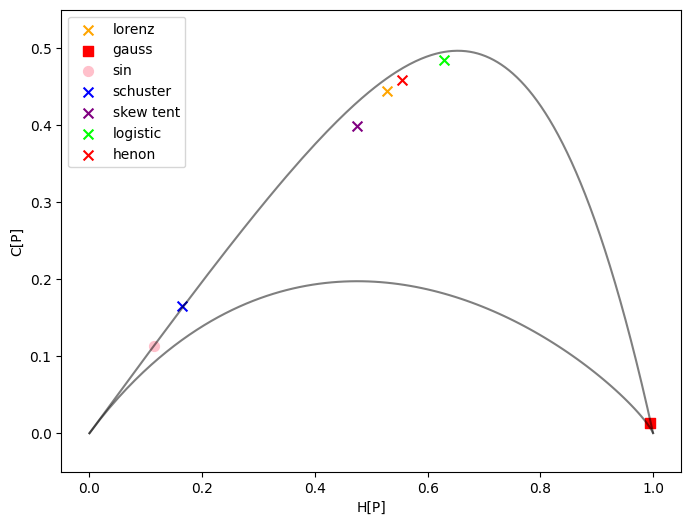

In [159]:
plt.figure(figsize=(8,6))
plt.plot(*minimum_complexity_entropy(dx=6).T, c='k', alpha=0.5)
plt.plot(*maximum_complexity_entropy(dx=6).T, c='k', alpha=0.5)
for k, dot in res.items():
    plt.scatter(dot[0], dot[1], label=k, **styles[k])
plt.xlabel('H[P]')
plt.ylabel('C[P]')
plt.ylim(-0.05,0.55)
plt.xlim(-0.05,1.05)
plt.legend()
plt.show()

Исходя из полученных результатов, на графике entropy-complexity выделяется три группы временных рядов:

    1) Регулярные временные ряды в левой оконечности (синусоида и schuster)
    2) Хаотические временные ряды в верхней оконечности графика (lorenz, logistic, skew tent, henon)
    3) Стохастические временные ряды в правой нижней оконечности (белый шум)